# Flightpath characterization
In this notebook we look at the characterization of the flight path. Up until now we've just flown in a circle, parameterized by radius and speed. That's pretty boring for the optimization, so let's look at something more interesting.

## Imports

In [1]:
import sys
sys.path.insert(0, "../source/")
sys.path.insert(0, "../source/Noise/")
sys.path.insert(0, "../models/AdvectionDiffusion/settings/AdvectionDiffusion_FEniCS")
sys.path.insert(0, "../models/AdvectionDiffusion/Navigators")
sys.path.insert(0, "../models/AdvectionDiffusion/Detectors")

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

from InverseProblem import InverseProblem
from NoiseBayes import NoiseBayes

from FOM_stationary import FOM_stationary as FOM
from OEDUtility import OEDUtility
from Drone import Drone as Drone

from DetectorPointwise import DetectorPointwise
from DetectorUniform import DetectorUniform
from DetectorGaussian import DetectorGaussian
from DetectorTruncGaussian import DetectorTruncGaussian

# specify which navigation class we are using
from NavigationSegment import NavigationSegment as Navigation
from NavigationMultiSegment import NavigationMultiSegment as NavigationMulti

import time
tStart_notebook = time.time()

## User settings

In [2]:
centers = [[0.4, 0.6], [0.6, 0.4]]
var_prior = 1 # set to a high value (1e+6) to test convergence in noise-free situations

n_steps = 5000

sigma = 0.05  # std deviation for gaussian-type measurements. Get pointwise data for sigma -> 0
radius = 0.05  # truncation radius for truncation-style measurements

meshDim = 20  # discretization parameter (1D) for FOM
meshDim_drone = 10  # discretization parameter (1D) for subdomain in truncation-type measurements
polyDim = 3

n_test = 100 # resolution for 1D plots

## Setup

In [3]:
tStart = time.time()

# initialize full-order model
fom = FOM(meshDim = meshDim, centers=centers, polyDim=polyDim)
n_para = fom.n_para

# set a prior
prior_mean = np.zeros((n_para,))
prior_covar = var_prior*np.eye(n_para)
fom.set_prior(prior_mean=prior_mean, prior_covar=prior_covar)

# NavigationCircle was imported as Navigation
navigation = Navigation(grid_t = np.linspace(0, 1, n_steps))

# point-wise measurements
detector = DetectorPointwise(fom)

# initialize drone
drone = Drone(detector=detector, navigation=navigation, fom=fom)

# set noise model
noise = NoiseBayes(grid_t = drone.grid_t)
noise.parameterize_noise_model(c_scaling = 1e+3, c_diffusion = 1)
inversion = InverseProblem(fom, drone, noise=noise)

# initialize utility functions
utility = OEDUtility(inversion)

print("Runtime of this block: {} s".format(time.time()-tStart))

Runtime of this block: 0.387937068939209 s


In [4]:
# compute one solution for nicer visualization below
para_true = np.ones((n_para,))
state = fom.solve(parameter=para_true)

## Path characterization

In [5]:
alpha_middle = np.array([0.9, 0.8, 3, 0.2, 0.5])
# initial-x, initial-y, heading, velocity, angular-velocity

(-0.05, 1.05)

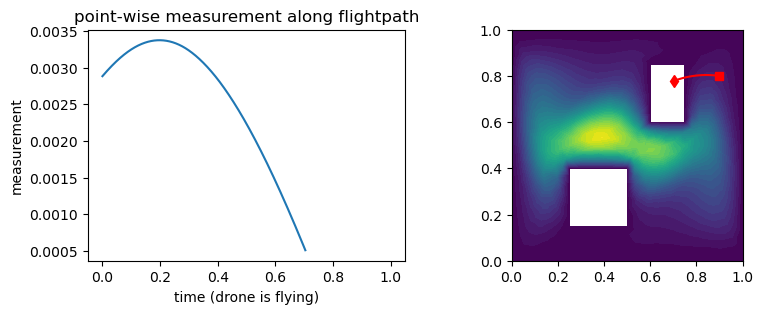

In [6]:
# compute flight
flight = drone.plan_flight(alpha=alpha_middle, grid_t=drone.grid_t)  # Flight object
flightpath, grid_t = flight.flightpath, flight.grid_t  # path and its time discretization

# measure data
data = drone.measure(flight=flight, state=state)

fig, axs = plt.subplots(1, 2, figsize = (9, 3))
fom.plot(state, ax=axs[0])
axs[1].plot(flightpath[:, 0], flightpath[:, 1], color="r")
axs[1].plot([flightpath[0, 0]], [flightpath[0, 1]], color="r", marker="s")
axs[1].plot([flightpath[-1, 0]], [flightpath[-1, 1]], color="r", marker="d")

axs[0].plot(grid_t, data)
axs[0].set_xlabel("time (drone is flying)")
axs[0].set_ylabel("measurement")
axs[0].set_title("point-wise measurement along flightpath")
axs[0].set_xlim(grid_t[0]-0.05, grid_t[-1]+0.05)

It is very, very important that we are not just treating missing measurements as zero. Remember that we are using a correlated noise model. Substituting missing measurements with zero is not the same as taking them out.

In [7]:
# compute posterior
posterior_ref = inversion.compute_posterior(alpha=alpha_middle)
util_ref = [utility.eval_utility(posterior_ref, mode="A"), utility.eval_utility(posterior_ref, mode="D")]
d_util_ref = [utility.d_utility_d_control(posterior_ref, mode="A"), utility.d_utility_d_control(posterior_ref, mode="D")]

print("A-OED:", util_ref[0])
print("D-OED:", util_ref[1])
print("E-OED:", utility.eval_utility(posterior_ref, mode="E"))

/Users/nicole/git/m2dtIceSheet/notebooks/../source/InverseProblem.py:240: UserWarning: InverseProblem.get_states: No saved states. Computing and saving with standard basis.
  warnings.warn(


we are in Posterior.d_invPostCov_d_position
A-OED: 1.976985946390851
D-OED: 0.9769860029917505
E-OED: 0.9999975403312048


In [8]:
directions = np.zeros((n_test, 5))

directions[:, 0] = np.linspace(0, 1, n_test) # initial x position
directions[:, 1] = np.linspace(0, 1, n_test) # initial y position
directions[:, 2] = np.linspace(0, 2*np.pi, n_test) # initial heading (in radian)
directions[:, 3] = np.linspace(0, 2*alpha_middle[3], n_test) # velocity

yolo = np.max([5, 2*np.abs(alpha_middle[4])])
directions[:, 4] = np.linspace(-yolo, yolo, n_test) # angular velocity

# directions[:, 0] = np.linspace(0.99*alpha_middle[0], 1.01*alpha_middle[0], n_test) # initial x position
# directions[:, 1] = np.linspace(0.99*alpha_middle[1], 1.01*alpha_middle[1], n_test) # initial y position
# directions[:, 2] = np.linspace(0.99*alpha_middle[2], 1.01*alpha_middle[2], n_test) # initial heading (in radian)
# directions[:, 3] = np.linspace(0.99*alpha_middle[3], 1.01*alpha_middle[3], n_test) # velocity
# directions[:, 4] = np.linspace(0.99*alpha_middle[4], 1.01*alpha_middle[4], n_test) # angular velocity

utils = np.zeros((n_test, 5, 2))
for i in range(n_test):
    if not i % 10: 
        print("iteration {} / {}".format(i+1, n_test))
    
    for j in range(5):
        alpha = alpha_middle.copy()
        alpha[j] = directions[i, j]
        
        posterior = inversion.compute_posterior(alpha=alpha)
        utils[i,j,0] = utility.eval_utility(posterior, mode="A")
        utils[i,j,1] = utility.eval_utility(posterior, mode="D")



iteration 1 / 100
iteration 11 / 100
iteration 21 / 100
iteration 31 / 100
iteration 41 / 100
iteration 51 / 100
iteration 61 / 100
iteration 71 / 100
iteration 81 / 100
iteration 91 / 100


Text(0, 0.5, 'D-OED utility')

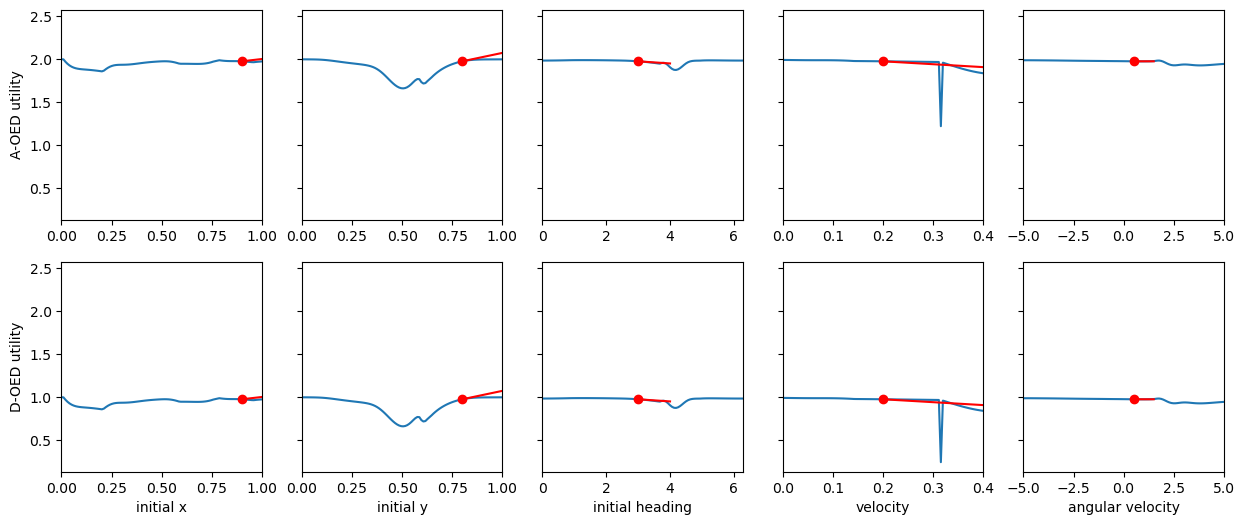

In [9]:
names_control = ["initial x", "initial y", "initial heading", "velocity", "angular velocity"]

fig, axs = plt.subplots(2, 5, figsize = (15, 6), sharey=True)

for j in range(5):
    for i in range(2):
        
        axs[i,j].plot(directions[:, j], utils[:, j, i])
        axs[i,j].plot(alpha_middle[j], util_ref[i], marker = "o", color = "r") # reference value
        axs[i,j].plot([alpha_middle[j], alpha_middle[j]+1], 
                      [util_ref[i], util_ref[i]+d_util_ref[i][j]], color="r") # reference derivative
        
        axs[i,j].set_xlim(directions[0,j], directions[-1, j])
        
        
    axs[1,j].set_xlabel(names_control[j])
    
axs[0, 0].set_ylabel("A-OED utility")
axs[1, 0].set_ylabel("D-OED utility")
#axs[0, 0].set_ylim(-0.25, 2.25)

In [10]:
# fig, ax = plt.subplots(1,1)

# i = 0
# j = 0

# ax.plot((utils[1:, i, j]-utils[:-1, i, j])/(directions[1, i]-directions[0,i]))
# ax.set_xlim(0, n_test)
# ax.plot([0, 50000],[d_util_ref[j][i], d_util_ref[j][i]])


## Multi-Segment

Flying in a single curve is much too boring, really we want to fly along a more complicated path. The way we model it here is by puzzling several segments together:

## continuous heading

In [11]:
transition_times = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])

# initialize navigation
navigation = NavigationMulti(grid_t = np.linspace(0, 1, n_steps), 
                             transition_times = transition_times, 
                             subcontrols=[3, 4])

# initialize drone
drone = Drone(detector=detector, navigation=navigation, fom=fom)

# set noise model
noise = NoiseBayes(grid_t = drone.grid_t)
noise.parameterize_noise_model(c_scaling = 1e+3, c_diffusion = 1)
inversion = InverseProblem(fom, drone, noise=noise)

# initialize utility functions
utility = OEDUtility(inversion)

In [12]:
alpha_middle = np.array([0.8, 0.4, 3, 1, 0, 
                         1, -2, 
                         1, 5, 
                         1, -10, 
                         1, -5])
# initial-x, initial-y, heading, velocity, angular-velocity for first segment,
# velocity, angular velocity for second segment

(-0.05, 1.05)

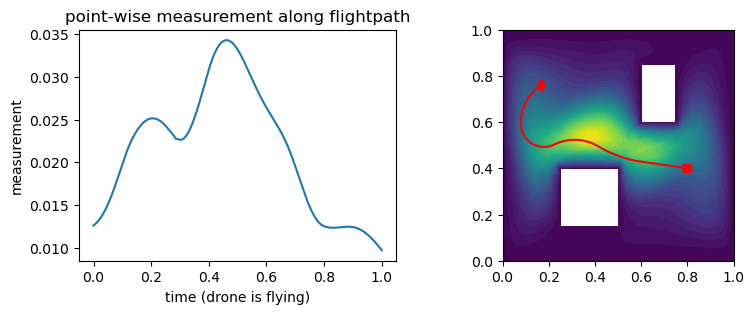

In [13]:
# compute flight
flight = drone.plan_flight(alpha=alpha_middle, grid_t=drone.grid_t)  # Flight object
flightpath, grid_t = flight.flightpath, flight.grid_t  # path and its time discretization

# measure data
data = drone.measure(flight=flight, state=state)

fig, axs = plt.subplots(1, 2, figsize = (9, 3))
fom.plot(state, ax=axs[0])
axs[1].plot(flightpath[:, 0], flightpath[:, 1], color="r")
axs[1].plot([flightpath[0, 0]], [flightpath[0, 1]], color="r", marker="s")
axs[1].plot([flightpath[-1, 0]], [flightpath[-1, 1]], color="r", marker="d")

axs[0].plot(grid_t, data)
axs[0].set_xlabel("time (drone is flying)")
axs[0].set_ylabel("measurement")
axs[0].set_title("point-wise measurement along flightpath")
axs[0].set_xlim(grid_t[0]-0.05, grid_t[-1]+0.05)

In [14]:
# compute posterior
posterior = inversion.compute_posterior(alpha=alpha_middle)
util_ref = [utility.eval_utility(posterior, mode="A"), utility.eval_utility(posterior, mode="D")]
d_util_ref = [utility.d_utility_d_control(posterior, mode="A"), utility.d_utility_d_control(posterior, mode="D")]

print("A-OED:", util_ref[0])
print("D-OED:", util_ref[1])
print("E-OED:", utility.eval_utility(posterior, mode="E"))

we are in Posterior.d_invPostCov_d_position
A-OED: 0.5092563470436817
D-OED: 0.051084485327553754
E-OED: 0.3718929228010465


### discontinuous heading

In [15]:
transition_times = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])

# initialize navigation
navigation = NavigationMulti(grid_t = np.linspace(0, 1, n_steps), 
                             transition_times = transition_times, subcontrols = [2, 3, 4])

# initialize drone
drone = Drone(detector=detector, navigation=navigation, fom=fom)

# set noise model
noise = NoiseBayes(grid_t = drone.grid_t)
noise.parameterize_noise_model(c_scaling = 1e+3, c_diffusion = 1)
inversion = InverseProblem(fom, drone, noise=noise)

# initialize utility functions
utility = OEDUtility(inversion)

In [16]:
alpha_middle = np.array([0.8, 0.4, 2, 0.5, 0, 
                         3, 2, 0, 
                         2, 1, 0, 
                         0, 0.5, 0, 
                         -1, 0.5, 0])
# initial-x, initial-y, heading, velocity, angular-velocity for first segment,
# heading, velocity, angular velocity for remaining segments

(-0.05, 1.05)

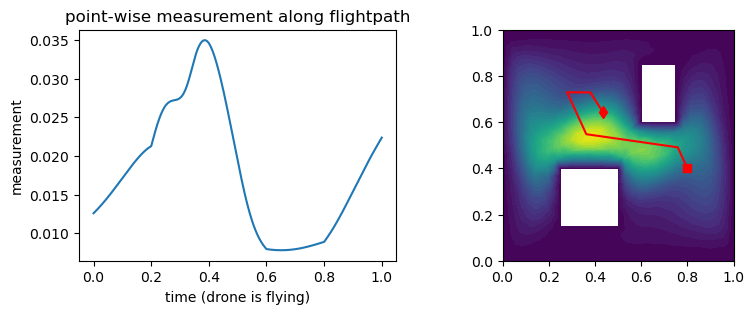

In [17]:
# compute flight
flight = drone.plan_flight(alpha=alpha_middle, grid_t=drone.grid_t)  # Flight object
flightpath, grid_t = flight.flightpath, flight.grid_t  # path and its time discretization

# measure data
data = drone.measure(flight=flight, state=state)

fig, axs = plt.subplots(1, 2, figsize = (9, 3))
fom.plot(state, ax=axs[0])
axs[1].plot(flightpath[:, 0], flightpath[:, 1], color="r")
axs[1].plot([flightpath[0, 0]], [flightpath[0, 1]], color="r", marker="s")
axs[1].plot([flightpath[-1, 0]], [flightpath[-1, 1]], color="r", marker="d")

axs[0].plot(grid_t, data)
axs[0].set_xlabel("time (drone is flying)")
axs[0].set_ylabel("measurement")
axs[0].set_title("point-wise measurement along flightpath")
axs[0].set_xlim(grid_t[0]-0.05, grid_t[-1]+0.05)

In [18]:
# compute posterior
posterior = inversion.compute_posterior(alpha=alpha_middle)
util_ref = [utility.eval_utility(posterior, mode="A"), utility.eval_utility(posterior, mode="D")]
d_util_ref = [utility.d_utility_d_control(posterior, mode="A"), utility.d_utility_d_control(posterior, mode="D")]

print("A-OED:", util_ref[0])
print("D-OED:", util_ref[1])
print("E-OED:", utility.eval_utility(posterior, mode="E"))

we are in Posterior.d_invPostCov_d_position
A-OED: 0.38001951715643767
D-OED: 0.022417435609598996
E-OED: 0.3069981030632743


### fixed controls, vary heading

In [19]:
transition_times = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])

# initialize navigation
navigation = NavigationMulti(grid_t = np.linspace(0, 1, n_steps), 
                             transition_times = transition_times, subcontrols = [2])
navigation.fix_controls(fixed_control_indices=[3, 4], fixed_control_values=[1, 0])

# initialize drone
drone = Drone(detector=detector, navigation=navigation, fom=fom)

# set noise model
noise = NoiseBayes(grid_t = drone.grid_t)
noise.parameterize_noise_model(c_scaling = 1e+3, c_diffusion = 1)
inversion = InverseProblem(fom, drone, noise=noise)

# initialize utility functions
utility = OEDUtility(inversion)

In [20]:
alpha_middle = np.array([0.8, 0.4, 2, 
                         4, 2, 3, 2])
# initial-x, initial-y, heading, velocity, angular-velocity for first segment,
# heading for remaining segments

(-0.05, 1.05)

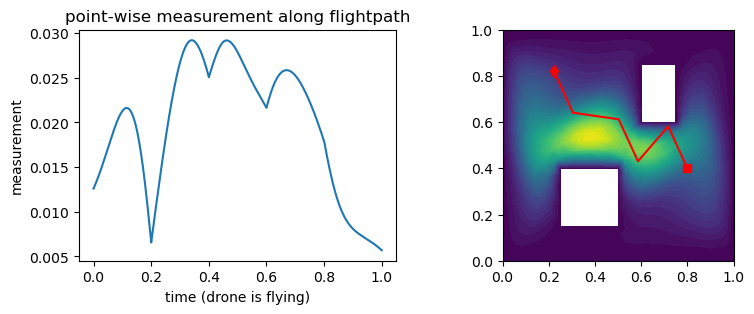

In [21]:
# compute flight
flight = drone.plan_flight(alpha=alpha_middle, grid_t=drone.grid_t)  # Flight object
flightpath, grid_t = flight.flightpath, flight.grid_t  # path and its time discretization

# measure data
data = drone.measure(flight=flight, state=state)

fig, axs = plt.subplots(1, 2, figsize = (9, 3))
fom.plot(state, ax=axs[0])
axs[1].plot(flightpath[:, 0], flightpath[:, 1], color="r")
axs[1].plot([flightpath[0, 0]], [flightpath[0, 1]], color="r", marker="s")
axs[1].plot([flightpath[-1, 0]], [flightpath[-1, 1]], color="r", marker="d")

axs[0].plot(grid_t, data)
axs[0].set_xlabel("time (drone is flying)")
axs[0].set_ylabel("measurement")
axs[0].set_title("point-wise measurement along flightpath")
axs[0].set_xlim(grid_t[0]-0.05, grid_t[-1]+0.05)

In [22]:
# compute posterior
posterior = inversion.compute_posterior(alpha=alpha_middle)
util_ref = [utility.eval_utility(posterior, mode="A"), utility.eval_utility(posterior, mode="D")]
d_util_ref = [utility.d_utility_d_control(posterior, mode="A"), utility.d_utility_d_control(posterior, mode="D")]

print("A-OED:", util_ref[0])
print("D-OED:", util_ref[1])
print("E-OED:", utility.eval_utility(posterior, mode="E"))

we are in Posterior.d_invPostCov_d_position
A-OED: 0.299105437540395
D-OED: 0.018474811595060304
E-OED: 0.21193223541226097


### fixed controls, vary angular velocity

In [23]:
transition_times = np.array([0, 0.5, 1])

# initialize navigation
navigation = NavigationMulti(grid_t = np.linspace(0, 1, n_steps), 
                             transition_times = transition_times, subcontrols = [3, 4])
navigation.fix_controls(fixed_control_indices=[], fixed_control_values=[])

# initialize drone
drone = Drone(detector=detector, navigation=navigation, fom=fom)

# set noise model
noise = NoiseBayes(grid_t = drone.grid_t)
noise.parameterize_noise_model(c_scaling = 1e+3, c_diffusion = 1)
inversion = InverseProblem(fom, drone, noise=noise)

# initialize utility functions
utility = OEDUtility(inversion)

In [24]:
alpha_middle = np.array([0.8, 0.4, 2.3, 0.4, 1, 
                         0.5, 0])
# initial-x, initial-y, heading, velocity, angular-velocity for first segment,
# heading for remaining segments

(-0.05, 1.05)

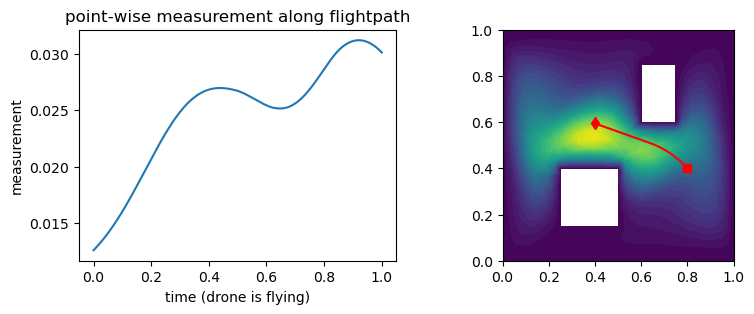

In [25]:
# compute flight
flight = drone.plan_flight(alpha=alpha_middle, grid_t=drone.grid_t)  # Flight object
flightpath, grid_t = flight.flightpath, flight.grid_t  # path and its time discretization

# measure data
data = drone.measure(flight=flight, state=state)

fig, axs = plt.subplots(1, 2, figsize = (9, 3))
fom.plot(state, ax=axs[0])
axs[1].plot(flightpath[:, 0], flightpath[:, 1], color="r")
axs[1].plot([flightpath[0, 0]], [flightpath[0, 1]], color="r", marker="s")
axs[1].plot([flightpath[-1, 0]], [flightpath[-1, 1]], color="r", marker="d")

axs[0].plot(grid_t, data)
axs[0].set_xlabel("time (drone is flying)")
axs[0].set_ylabel("measurement")
axs[0].set_title("point-wise measurement along flightpath")
axs[0].set_xlim(grid_t[0]-0.05, grid_t[-1]+0.05)

In [26]:
# compute posterior
posterior = inversion.compute_posterior(alpha=alpha_middle)
util_ref = [utility.eval_utility(posterior, mode="A"), utility.eval_utility(posterior, mode="D")]
d_util_ref = [utility.d_utility_d_control(posterior, mode="A"), utility.d_utility_d_control(posterior, mode="D")]

print("A-OED:", util_ref[0])
print("D-OED:", util_ref[1])
print("E-OED:", utility.eval_utility(posterior, mode="E"))

we are in Posterior.d_invPostCov_d_position
A-OED: 0.8607516168907448
D-OED: 0.16060957902646478
E-OED: 0.5872635309367868


In [27]:
directions = np.zeros((n_test, 7))

directions[:, 0] = np.linspace(0, 1, n_test) # initial x position
directions[:, 1] = np.linspace(0, 1, n_test) # initial y position
directions[:, 2] = np.linspace(0, 2*np.pi, n_test) # initial heading (in radian)
directions[:, 3] = np.linspace(0, 2*alpha_middle[3], n_test) # velocity, interval 1

yolo = np.max([5, 2*np.abs(alpha_middle[4])])
directions[:, 4] = np.linspace(-yolo, yolo, n_test) # angular velocity, interval 1

directions[:, 5] = directions[:, 3] # velocity, interval 2
directions[:, 6] = directions[:, 4] # angular velocity, interval 2

utils = np.zeros((n_test, 7, 2))
for i in range(n_test):
    if not i % 10: 
        print("iteration {} / {}".format(i+1, n_test))
    
    for j in range(7):
        alpha = alpha_middle.copy()
        alpha[j] = directions[i, j]
        
        posterior = inversion.compute_posterior(alpha=alpha)
        utils[i,j,0] = utility.eval_utility(posterior, mode="A")
        utils[i,j,1] = utility.eval_utility(posterior, mode="D")

iteration 1 / 100
iteration 11 / 100
iteration 21 / 100
iteration 31 / 100
iteration 41 / 100
iteration 51 / 100
iteration 61 / 100
iteration 71 / 100
iteration 81 / 100
iteration 91 / 100


(-0.25, 2.25)

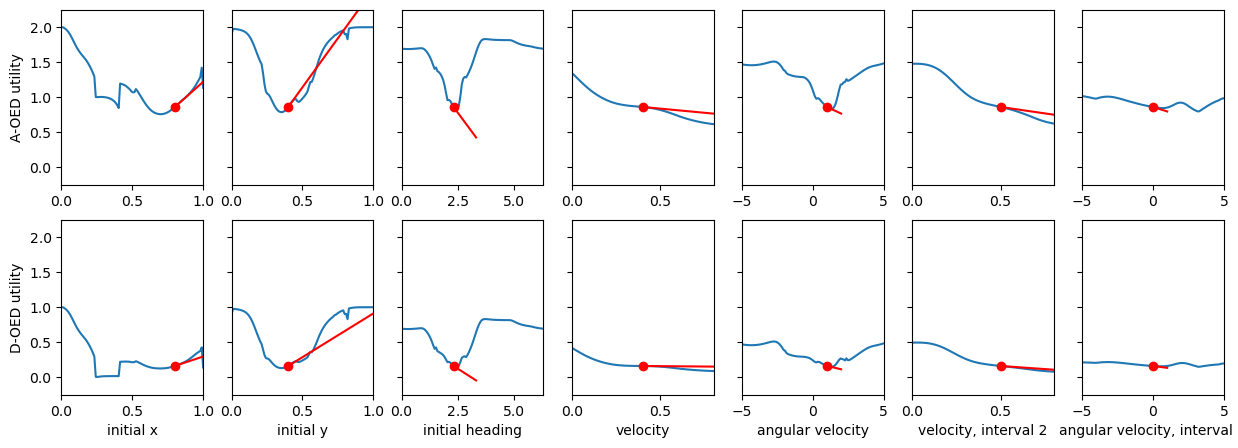

In [28]:
names_control = ["initial x", "initial y", "initial heading", 
                 "velocity", "angular velocity", 
                 "velocity, interval 2", "angular velocity, interval 2"]

fig, axs = plt.subplots(2, 7, figsize = (15, 5), sharey=True)

for j in range(7):
    for i in range(2):
        
        axs[i,j].plot(directions[:, j], utils[:, j, i])
        axs[i,j].plot(alpha_middle[j], util_ref[i], marker = "o", color = "r") # reference value
        axs[i,j].plot([alpha_middle[j], alpha_middle[j]+1], 
                      [util_ref[i], util_ref[i]+d_util_ref[i][j]], color="r") # reference derivative
        
        axs[i,j].set_xlim(directions[0,j], directions[-1, j])
        
        
    axs[1,j].set_xlabel(names_control[j])
    
axs[0, 0].set_ylabel("A-OED utility")
axs[1, 0].set_ylabel("D-OED utility")
axs[0, 0].set_ylim(-0.25, 2.25)

**Welcome back!** Next steps:
- fix computation of derivatives. I think the issue is when the flight path overlaps with the domain boundary. We need to adjust the noise covaraiance matrices. For the L2 case, everything looks fine, but even then we should adjust the covariance matrix
- compare to Thomas' derivatives

## Optimization

Let's outsource the optimization to a different notebook.

## The End.

In [29]:
runtime_notebook = time.time()-tStart_notebook
print("Runtime of this notebook: {} min".format(runtime_notebook / 60))

Runtime of this notebook: 3.853064501285553 min
